In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
# from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
#                                cartesian2spherical, GCD_cartesian, shape, GCD_cartesian)                              
# from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import (running_mean_APWP_shape, get_pseudo_vgps, MC_error_prop_ensemble_results)
# from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles, PC
from vgptools.utils_classes import PC, quantiles
np.random.seed(1)

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
# df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True) # takes as many as poles as are described for one are
df_filtered_vgps = pd.read_csv(current_path +'/data/df_vgps_filtered.csv')
df_pole_compilation  = pd.read_csv(current_path +'/data/df_pole_compilation_by_study.csv')

## Set the hyperparameters for further comparissons.

In [4]:
min_age = 0
max_age = 65
window_length = 20
time_step = 10
# define a list to store all the models
models = []

### 1. Running means classic approach on poles

In [5]:
RM_1_classic = running_mean_APWP_shape(df_pole_compilation, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_1_classic['method'] = "RM_classic"
models.append(RM_1_classic)
RM_1_classic.head(10)

,age,N,n_studies,k,A95,csd,plon,plat,foliation,lineation,collinearity,coplanarity,elong_dir,GCD,APW_rate,angle,method
0,0.0,17.0,15.0,155.075584,2.873466,6.504491,0.000000,-90.000000,0.673561,4.819217,7.154834,5.492778,52.950148,NaN,NaN,NaN,RM_classic
1,10.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,0.699943,4.806285,6.866678,5.506228,48.438290,0.375266,0.037527,163.155600,RM_classic
2,20.0,7.0,6.0,576.253052,2.516820,3.374259,-11.644529,-81.643535,2.379876,5.904994,2.481219,8.284869,28.613948,6.633272,0.663327,35.000034,RM_classic
3,30.0,10.0,7.0,352.037229,2.578271,4.317086,-27.417630,-82.908968,3.219457,5.313450,1.650418,8.532907,28.978465,2.457136,0.245714,174.787778,RM_classic
4,40.0,13.0,8.0,106.788061,4.029946,7.838332,-42.018275,-83.233935,1.211546,4.320118,3.565790,5.531664,-94.770122,1.785938,0.178594,29.497476,RM_classic
5,50.0,12.0,9.0,83.449008,4.779163,8.866953,-27.811855,-81.677918,0.806618,4.186000,5.189566,4.992618,-92.200769,2.417822,0.241782,178.060425,RM_classic
6,60.0,4.0,4.0,222.541387,6.172545,5.429747,-13.837826,-78.640250,1.695166,5.163581,3.046062,6.858747,-34.503896,3.843211,0.384321,NaN,RM_classic


### 2. Running means ensemble from $pseudo$-VGPs approach (Vaes et al. 2022)

In [6]:
min_age = 0
max_age = 65
window_length = 22
time_step = 1

quantile = 95

In [7]:
%%time
RM_2_ensemble_pseudoVGP = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):   
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP_shape(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i
    RM_APWP_parametric_temp['plon'] = RM_APWP_parametric_temp['plon'].apply(lambda plon: plon - 360 if plon > 180 else plon)    
    RM_APWP_parametric_temp['method'] = "RM_pseudoVGPs_ensemble"   
       
    RM_2_ensemble_pseudoVGP = RM_2_ensemble_pseudoVGP.append(RM_APWP_parametric_temp, ignore_index=True)

models.append(RM_2_ensemble_pseudoVGP)

CPU times: user 1min 30s, sys: 476 ms, total: 1min 31s
Wall time: 1min 31s


### Calcultes the Princ. Components of the ensemble

In [8]:
# Since the Latitude and Longitude covaries, we need to calculate the Principal component for each timre-dependant point Cloud 
ensemble_PC_Vaes = PC(RM_2_ensemble_pseudoVGP,"age","plat","plon") # set principal component for each Age

### 3.3. Propation of directional error towards the VGP level. 
We take the original directions as a PDF to generate to generate a pseudo-Dataset that incorporates the uncertinty in the directional space and time. We aaply the running means on a number of $pseudo$-VGPs to generate an ensemble of possible paths

In [10]:
%%time
df_RM_ensemble = ensemble_RMs(df_directions, n_bst = 50,
                 study_label= 'Study', slat_label='slat', slon_label='slon',
                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                 window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)


NameError: name 'ensemble_RMs' is not defined

### Calcultes the Princ. Components of the ensemble

In [11]:
ensemble_PC_Gallo = PC(df_RM_ensemble,"age","plat","plon") # set principal component for each Age

NameError: name 'df_RM_ensemble' is not defined

# Comparisons plot

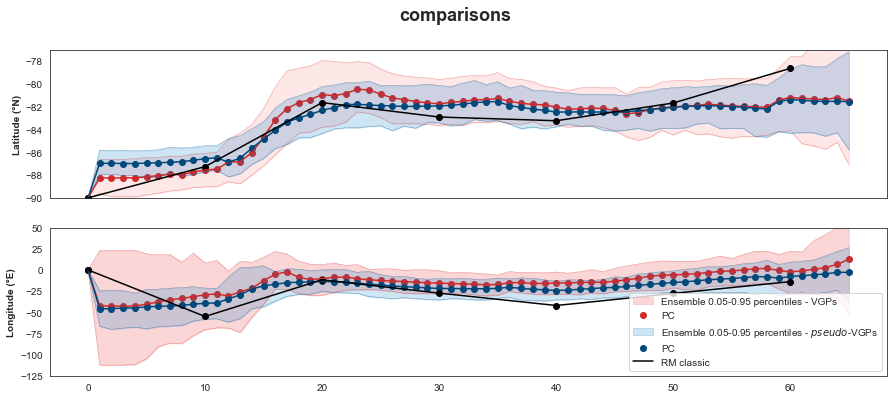

In [67]:
title = "comparisons"

quantile = 95

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
# axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
# axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')

axes[0].set_ylim(-90,-77)
axes[1].set_ylim(-125,50)
# LATITUDE
# Gallo
axes[0].fill_between(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[2], ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[3], color= "#f98787", alpha=.20)
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[3],color="#d12a2a",linewidth=0.2)
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[2],color="#d12a2a",linewidth=0.2)
axes[0].scatter(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[1],color="#d12a2a")
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[1],color="#d12a2a")
# Vaes
axes[0].fill_between(ensemble_PC_Vaes.X,ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[2],ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[3], color= "#0E7DC9", alpha=.20)
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[3],color="#00497A",linewidth=0.2)
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[2],color="#00497A",linewidth=0.2)
axes[0].scatter(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[1],color="#00497A")
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[1],color="#00497A")
#CLASSIC
axes[0].plot(RM_1_classic.age, RM_1_classic.plat, '-',color="black") #CLASSIC
axes[0].scatter(RM_1_classic.age, RM_1_classic.plat, color="black") #CLASSIC


# LONGITUDE
# Gallo
axes[1].fill_between(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[0], ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[1], color= "#f9afaf", alpha=.50,label=f"Ensemble {1-quantile/100:.2f}-{quantile/100:.2f} percentiles - VGPs")
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[1],color="#d12a2a",linewidth=0.2)
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[0],color="#d12a2a",linewidth=0.2)
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[0], '-',color="#d12a2a")
axes[1].scatter(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[0],color="#d12a2a",label="PC")
# Vaes
axes[1].fill_between(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[0], ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[1], color= "#0E7DC9", alpha=.20,label=f"Ensemble {1-quantile/100:.2f}-{quantile/100:.2f} percentiles - $pseudo$-VGPs")
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[1],color="#00497A",linewidth=0.2)
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[0],color="#00497A",linewidth=0.2)
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[0], '-',color="#00497A")
axes[1].scatter(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[0],color="#00497A",label="PC")
# Classic
axes[1].plot(RM_1_classic.age, RM_1_classic.plon, '-',color="black", label = "RM classic") #CLASSIC
axes[1].scatter(RM_1_classic.age, RM_1_classic.plon, color="black") #CLASSIC

plt.legend(loc="lower right")
# plt.savefig(current_path + '/figures/6/6a.svg', dpi =600, bbox_inches='tight')